In [1]:
# Fix for issue loading Utils.preprocess_util
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from Utils.preprocess_util import *
from Utils.visualize import *

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2


In [35]:
person_train_valid = np.load('../Data/person_train_valid.npy')
print(person_train_valid.shape)

(2115, 1)


In [9]:
print(np.unique(person_train_valid))

[0. 1. 2. 3. 4. 5. 6. 7. 8.]


In [17]:
a = np.array([1,2,4,5,1,4,1,5])
c = np.argwhere(a==4)

b = np.array([11,21,41,15,11,43,13,56])
print(b[c])

[[41]
 [43]]


In [ ]:
X_train,X_valid,X_test,Y_train,Y_valid,Y_test = load_preprocess_eeg_data(person=None,crop=True)


(2115, 22, 1000)
Cropping trials


In [28]:
indices = np.random.choice(X_train.shape[0], X_train.shape[0], replace=False)
X_train = X_train[indices]
Y_train = Y_train[indices]





In [96]:
X_train_small = X_train[0:1000]
Y_train_small = Y_train[0:1000]

In [29]:
indices = np.random.choice(X_valid.shape[0], X_valid.shape[0], replace=False)
X_valid = X_valid[indices]
Y_valid = Y_valid[indices]

indices = np.random.choice(X_test.shape[0], X_test.shape[0], replace=False)
X_test = X_test[indices]
Y_test = Y_test[indices]

In [46]:
print(X_train.shape)

(177125, 22, 500)


In [30]:
# create feature and targets tensor for train set
features_train = torch.from_numpy(X_train)
targets_train = torch.from_numpy(Y_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set
features_test = torch.from_numpy(X_test)
targets_test = torch.from_numpy(Y_test).type(torch.LongTensor)

features_valid = torch.from_numpy(X_valid)
targets_valid = torch.from_numpy(Y_valid).type(torch.LongTensor)


In [31]:
class LSTMModel(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs,n_layers,droput):
        super(LSTMModel, self).__init__()
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.num_layers = n_layers
        self.lstm = nn.LSTM(self.n_inputs, self.n_neurons,self.num_layers) 
        #self.lstm.weight_hh_l0.data.fill_(0)
        #torch.nn.init.xavier_uniform_(self.lstm.weight_ih_l0.data )
        #torch.nn.init.orthogonal_(self.lstm.weight_hh_l0.data)
        
        #initialising w(rec) to I and b(rec) to 0 
        ih_size = list(self.lstm.weight_ih_l0.data.shape)
        hh_size =list(self.lstm.weight_hh_l0.data.shape)
        self.lstm.weight_ih_l0.data.copy_(torch.eye(ih_size[0],ih_size[1]))
        self.lstm.weight_hh_l0.data.copy_(torch.eye(hh_size[0],hh_size[1]))
        
        self.lstm.bias_ih_l0.data.fill_(0)
        self.lstm.bias_hh_l0.data.fill_(0)
        
        self.droput = nn.Dropout(p=droput)
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
            # (num_layers, batch_size, n_neurons)
            return (torch.zeros(self.num_layers, self.batch_size, self.n_neurons))
            #return torch.nn.init.xavier_uniform_((self.num_layers, self.batch_size, self.n_neurons), gain=1)

    def forward(self, X):
            # transforms X to (n_steps, batch_size, n_inputs)
            X = X.permute(1, 0, 2) 
            self.batch_size = X.size(1)
            self.hidden = self.init_hidden()
            self.cellstate = self.init_hidden()
            lstm_out, (self.hidden, self.cellstate)= self.lstm(X, (self.hidden,self.cellstate))
            hidden_out =self.hidden[self.num_layers-1]
            dropout_out = self.droput(hidden_out)
            out = self.FC(dropout_out)

            return out.view(-1, self.n_outputs) # (batch_size, n_output)


In [32]:
batch_size = 500
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(features_train, targets_train)
valid = torch.utils.data.TensorDataset(features_valid, targets_valid)
test = torch.utils.data.TensorDataset(features_test, targets_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

# pprint.pprint(test_loader.dataset.tensors[0].size())


In [2]:
N_STEPS = 500
N_INPUTS = 22
N_NEURONS = 75
N_OUTPUTS = 10
N_EPOCHS = 10
N_LAYERS = 1# This actually corresponds to how many lsts are stacked one above the other
droput = 0
dataiter = iter(train_loader)
images, labels = dataiter.next()
model = LSTMModel(batch_size, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS,N_LAYERS,droput)

# (batch_size, n_steps, n_inputs)
images_modified = images.view(-1, 500, 22)
logits = model(images_modified.float())
print(logits[0:10])

NameError: name 'train_loader' is not defined

In [1]:
dtype = torch.FloatTensor
n_iters = 10000
num_epochs = int(n_iters / (len(X_train)/batch_size))
model = LSTMModel(batch_size, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS,N_LAYERS,droput)

# Cross Entropy Loss 
loss_fn = nn.CrossEntropyLoss().type(dtype)

# batch GD
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01,weight_decay =0,betas=(0.9, 0.999),amsgrad=False)
#optimizer = torch.optim.RMSprop(model.parameters(),lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.1)

# Create RNN
input_dim = 22
seq_dim = 500

train_loss = []
iterations = []
train_acc = []

X_valid_tensor = torch.from_numpy(X_valid.reshape(-1, seq_dim, input_dim))
X_train_tensor = torch.from_numpy(X_train.reshape(-1, seq_dim, input_dim))

print("X=",X_train_tensor.shape)
print("num_epochs = ", num_epochs)
print("n_iters = ", n_iters)
print("starting training..")

count = 0
num_epochs = 2
print("starting training..")
for epoch in range(num_epochs):
    print("epoch=",epoch)
    # reset hidden states
    
    for i, (signals, labels) in enumerate(train_loader):
        train  = Variable(signals.view(-1, seq_dim, input_dim))
        labels = Variable(labels )
        
        # Clear gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
                
        # Forward propagation
        outputs = model(train.float())
        
        # Calculate softmax and cross entropy loss
        loss = loss_fn(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
                    
        #print("parameters===",list(model.parameters())[0].data)

        count += 1
        train_loss.append(loss.data)
        iterations.append(count)
        if count % 1 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            
            #indices = np.random.choice(X_train.shape[0], 50, replace=False)
            #X_train_tensor = torch.from_numpy(X_train[indices].reshape(-1, seq_dim, input_dim))
            #y_pred_valid = model( X_valid_tensor.float())
            #val_acc = get_accuracy(y_pred_valid, Y_valid,batch_size=X_valid.shape[0])
            
            y_pred_train = model( train.float())
            train_acc = get_accuracy(y_pred_train,labels,batch_size=labels.shape[0])
            
            indices = np.random.choice(X_valid.shape[0], 50, replace=False)
            
            X_valid_tensor = torch.from_numpy(X_valid[indices].reshape(-1, seq_dim, input_dim))
            
            y_pred_valid = model( X_valid_tensor.float())
            val_acc = get_accuracy(y_pred_valid, Y_valid[indices],
            batch_size=50)
            
            '''           
            for f in model.parameters():
                print('data is')
                print(f.data)
                print('grad is')
                print(f.grad)
            '''
            
            #print('Iteration: {}  Loss: {}' .format(count, loss.data))

            print('Iteration: {}  Loss: {}  Train Accuracy: {} Valid Accuracy: {} %'.format(count, loss.data,train_acc,
                                                                                            val_acc))
            #if(train_acc> 35 and val_acc>35):
                #return
            '''
            # Iterate through test dataset
            for signals, labels in valid_loader:
                signals = Variable(signals.view(-1, seq_dim, input_dim))
                #print(signals.shape)
                # Forward propagation
                outputs_valid = model(signals.float())

                # Get predictions from the maximum value
                predicted = torch.max(outputs_valid.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            train_loss.append(loss.data)
            iterations.append(count)
            train_acc.append(accuracy)
            print('Iteration: {}  Loss: {}  Valid Accuracy: {} %'.format(count, loss.data, accuracy))
          '''  
                                   

NameError: name 'torch' is not defined

In [16]:

# In case running this cell gives you an out-of-memory error, you can run the next cell 
#which breaks up the datasets into chunks to calculate the accuracy

X_train_tensor = torch.from_numpy(X_train.reshape(-1, seq_dim, input_dim))
print(X_train_tensor.shape)
y_pred_train = model( X_train_tensor.float())
train_acc = get_accuracy(y_pred_train, Y_train,
    batch_size=len(Y_train))
print('train accuracy:', train_acc)



X_valid_tensor = torch.from_numpy(X_valid.reshape(-1, seq_dim, input_dim))
print(X_valid_tensor.shape)
y_pred_valid = model( X_valid_tensor.float())
val_acc = get_accuracy(y_pred_valid, Y_valid,
    batch_size=len(Y_valid))
print('validation accuracy:', val_acc)

X_test_tensor = torch.from_numpy(X_test.reshape(-1, seq_dim, input_dim))
print(X_test_tensor.shape)
y_pred_test = model( X_test_tensor.float())
test_acc = get_accuracy(y_pred_test, Y_test,
    batch_size=len(Y_test))
print('test accuracy:', test_acc)


torch.Size([5000, 500, 22])
validation accuracy: 17.5


In [43]:
X_test_tensor = torch.from_numpy(X_test.reshape(-1, seq_dim, input_dim))
print(X_test_tensor.shape)
y_pred_test = model( X_test_tensor.float())
test_acc = get_accuracy(y_pred_test, Y_test,
    batch_size=len(Y_test))
print('test accuracy:', test_acc)


torch.Size([55375, 500, 22])


RuntimeError: $ Torch: not enough memory: you tried to allocate 0GB. Buy new RAM! at ..\aten\src\TH\THGeneral.cpp:201

In [35]:
#Calculating the validation accruacy in baaches, since out-of-memory error arises when calculating using the whole set!
datset_size =  X_valid.shape[0]
size_of_batches = int(datset_size/20)

print(datset_size)
print(size_of_batches)

start = 0

valid_accuracies = []
for i in range(20):
    end = start + size_of_batches
    
    X_valid_tensor = torch.from_numpy(X_valid[start:end].reshape(-1, seq_dim, input_dim))
    print(X_valid_tensor.shape)
    y_pred_valid = model( X_valid_tensor.float())
    val_acc = get_accuracy(y_pred_valid, Y_valid[start:end],
    batch_size=len(Y_valid[start:end]))
    start = end
    valid_accuracies.append(val_acc)

print('validation accuracy:', np.mean(valid_accuracies))


87250
4362
torch.Size([4362, 500, 22])
torch.Size([4362, 500, 22])
torch.Size([4362, 500, 22])
torch.Size([4362, 500, 22])
torch.Size([4362, 500, 22])
torch.Size([4362, 500, 22])
torch.Size([4362, 500, 22])
torch.Size([4362, 500, 22])
torch.Size([4362, 500, 22])
torch.Size([4362, 500, 22])
torch.Size([4362, 500, 22])
torch.Size([4362, 500, 22])
torch.Size([4362, 500, 22])
torch.Size([4362, 500, 22])
torch.Size([4362, 500, 22])
torch.Size([4362, 500, 22])
torch.Size([4362, 500, 22])
torch.Size([4362, 500, 22])
torch.Size([4362, 500, 22])
torch.Size([4362, 500, 22])
validation accuracy: 25.196011004126547


In [37]:
#Calculating the test accruacy in baaches, since out-of-memory error arises when calculating using the whole set!
datset_size =  X_test.shape[0]
size_of_batches = int(datset_size/20)

print(datset_size)
print(size_of_batches)

start = 0

test_accuracies = []
for i in range(20):
    end = start + size_of_batches
    
    X_test_tensor = torch.from_numpy(X_test[start:end].reshape(-1, seq_dim, input_dim))
    print(X_test_tensor.shape)
    y_pred_test = model( X_test_tensor.float())
    test_acc = get_accuracy(y_pred_test, Y_test[start:end],
    batch_size=len(Y_test[start:end]))
    start = end
    test_accuracies.append(test_acc)

print('Test accuracy:', np.mean(test_accuracies))


55375
2768
torch.Size([2768, 500, 22])
torch.Size([2768, 500, 22])
torch.Size([2768, 500, 22])
torch.Size([2768, 500, 22])
torch.Size([2768, 500, 22])
torch.Size([2768, 500, 22])
torch.Size([2768, 500, 22])
torch.Size([2768, 500, 22])
torch.Size([2768, 500, 22])
torch.Size([2768, 500, 22])
torch.Size([2768, 500, 22])
torch.Size([2768, 500, 22])
torch.Size([2768, 500, 22])
torch.Size([2768, 500, 22])
torch.Size([2768, 500, 22])
torch.Size([2768, 500, 22])
torch.Size([2768, 500, 22])
torch.Size([2768, 500, 22])
torch.Size([2768, 500, 22])
torch.Size([2768, 500, 22])
Test accuracy: 23.6235549132948


In [36]:
#Calculating the training accruacy in batches, since out-of-memory error arises when calculating using the whole set!
datset_size =  X_train.shape[0]
size_of_batches = int(datset_size/50)

print(datset_size)
print(size_of_batches)

start=end = 0

train_accuracies = []
for i in range(50):
    end = start + size_of_batches
    
    X_train_tensor = torch.from_numpy(X_train[start:end].reshape(-1, seq_dim, input_dim))
    print(X_train_tensor.shape)
    y_pred_train = model( X_train_tensor .float())
    train_acc = get_accuracy(y_pred_train, Y_train[start:end],
    batch_size=len(Y_train[start:end]))
    start = end
    train_accuracies.append(train_acc)

print('train accuracy:', np.mean(train_accuracies))


177125
3542
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Size([3542, 500, 22])
torch.Si

In [23]:
print('train_accuracy:', np.mean(train_accuracies))

validation accuracy: 23.90153582688275


In [ ]:
print(type(loss))

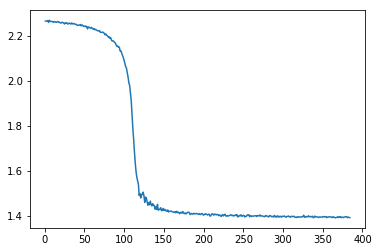

In [41]:
#plot loss vs iterations
import matplotlib.pyplot as plt
plt.plot(iterations,train_loss)
plt.show();